In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

## Passo 1: Leitura dos dados
Leitura dos bancos de dados em DataFrame Pandas. 

In [2]:
caminho_dados_lazaro = 'Datasets/Lazaro/dados_lazaro.csv'

In [3]:
df = pd.read_csv(caminho_dados_lazaro)

In [4]:
df.head()

,Piquete,Altura real,Altura esperada,Animal,SensorID,Sensor Name,Date,X,Y,Z,Comportamento,Season
0,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 08:25:30,-0.012,-0.456,0.900,Indefinido,Indefinido
1,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 08:25:32,-0.008,-0.456,0.892,Indefinido,Indefinido
2,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 08:25:33,-0.010,-0.460,0.897,Indefinido,Indefinido
3,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 08:25:33,0.021,-0.386,0.963,Indefinido,Indefinido
4,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 08:25:34,0.012,-0.423,0.910,Indefinido,Indefinido


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Função para calcular acuracia de cada etapa
def calc_acuracia(X_train, X_valid, y_train, y_valid):
    model = RandomForestClassifier(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    print("Acurácio da etapa:")
    print(accuracy_score(y_valid, preds)*100)

## Passo 2: Pré-processamento


### 2.0 Seleção de colunas aplicáveis

In [6]:
df.columns

Index(['Piquete', 'Altura real', 'Altura esperada', 'Animal', 'SensorID',
       'Sensor Name', 'Date', 'X', 'Y', 'Z', 'Comportamento', 'Season'],
      dtype='object')

In [7]:
# Lista com os atributos aplicáveis
features_aplicaveis = ['X', 'Y', 'Z', 'Comportamento', 'Season']

# Seleciona os abributos correspondentes da lista features_aplicaveis
df = df[features_aplicaveis]

### 2.1 Lidando com dados faltantes

In [8]:
df[df.isnull().any(axis=1)]

,X,Y,Z,Comportamento,Season
296,175786.0,NaN,NaN,Indefinido,Indefinido


In [9]:
df.isnull().sum()

X                0
Y                1
Z                1
Comportamento    0
Season           0
dtype: int64

In [10]:
# No entanto, durante a integração dos dados valores nulos em "Comportamento" e "Season" foram nomeados "Indefinido", logo temos que tratá-los
df.Comportamento.value_counts()

Pastejando     342516
Ruminando      158228
Ocio           126141
Indefinido      23496
Outros          19472
Locomovendo     12567
Agua             3779
Outro            2303
Ócio             2064
Name: Comportamento, dtype: int64

In [11]:
df = df.replace('Indefinido', np.NaN)

In [12]:
# Como praticamente não há valores faltantes nas variáveis independentes e há obeservações com variáveis alvo nulas, o melhor é apenas eliminar linhas com valores nulos
df = df.dropna(axis=0)
df.isnull().sum()

X                0
Y                0
Z                0
Comportamento    0
Season           0
dtype: int64

### 2.2 Tratamento de dados categóricos

#### Correção dos nomes das classificações

In [13]:
np.unique(df['Comportamento'])

array(['Agua', 'Locomovendo', 'Ocio', 'Outro', 'Outros', 'Pastejando',
       'Ruminando', 'Ócio'], dtype=object)

In [14]:
df = df.replace(to_replace=['Ócio','Outro'], value=['Ocio', 'Outros'])

In [15]:
np.unique(df['Season'])

array(['Spring', 'fall', 'spring', 'spring ', 'summer'], dtype=object)

In [16]:
df = df.replace(to_replace=['Spring','spring '], value=['spring', 'spring'])

#### Divisão entre variáveis preditoras(X) e variáveis de resposta(y)

In [46]:
X = df[['X', 'Y', 'Z', 'Season']]
y = df.Comportamento

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 0)

#### Codificação - Usando Ordinal Encoding

In [136]:
from sklearn.preprocessing import OrdinalEncoder

label_X_train = X_train.copy()
label_X_valid = X_valid.copy()

# Aplica ordinal encoder à coluna Season
ordinal_encoder = OrdinalEncoder()
label_X_train['Season'] = ordinal_encoder.fit_transform(X_train['Season'].values.reshape(-1,1))
label_X_valid['Season'] = ordinal_encoder.transform(X_valid['Season'].values.reshape(-1,1))

In [ ]:
calc_acuracia(label_X_train, label_X_valid, y_train, y_valid)

#### Codificação - Usando One-Hot Encoding

In [47]:
from sklearn.preprocessing import OneHotEncoder

# Aplica one-hot encoder à coluna Season
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train['Season'].values.reshape(-1,1)))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid['Season'].values.reshape(-1,1)))

In [48]:
# One-hot encoder remove os indices; recuperando-os
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

In [49]:
# Remoção da coluna Season (será substituida com one-hot encoding)
num_X_train = X_train.drop('Season', axis=1)
num_X_valid = X_valid.drop('Season', axis=1)

In [50]:
# Adiciona colunas codificadas por one-hot a features numéricas
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

In [51]:
calc_acuracia(OH_X_train, OH_X_valid, y_train, y_valid)

Acurácio da etapa:
68.94068406408903


In [52]:
# Get_dummies é suficente
# X = df[['X', 'Y', 'Z', 'Season']]
# X = pd.get_dummies(X)

### 2.3 Tratamento de outliers

In [83]:
X = df[['X', 'Y', 'Z', 'Season']]
y = df.Comportamento

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 0)

# Como one-hot encoder foi melhor, usaremos ele
X_train = OH_X_train
X_valid = OH_X_valid

#### Usando Isolation Forest

In [55]:
X_train.describe()

,X,Y,Z,0,1,2
count,500302.000000,500302.000000,500302.000000,500302.000000,500302.000000,500302.000000
mean,0.003847,0.076661,0.301881,0.397132,0.244940,0.357928
std,0.576718,0.580535,0.496833,0.489304,0.430052,0.479391
min,-1.999000,-2.688000,-1.999000,0.000000,0.000000,0.000000
25%,-0.495000,-0.391000,-0.020000,0.000000,0.000000,0.000000
50%,0.018000,0.137000,0.407000,0.000000,0.000000,0.000000
75%,0.475000,0.541000,0.687000,1.000000,0.000000,1.000000
max,2.106000,2.000000,2.020000,1.000000,1.000000,1.000000


In [23]:
X_train_array, y_train_array = X_train.values, y_train.values

In [24]:
print(X_train_array.shape, y_train_array.shape)

(500302, 6) (500302,)


In [25]:
from sklearn.ensemble import IsolationForest
# Identifica outliers no dataset de treino
iso = IsolationForest(contamination=0.1)
result = iso.fit_predict(X_train_array)

In [26]:
# Remove todas as linhas que têm outliers
mask = result != -1
X_train_array, y_train_array = X_train_array[mask, :], y_train_array[mask]
print(X_train_array.shape, y_train_array.shape)

(450271, 6) (450271,)


In [30]:
X_train_array

array([[ 0.804,  0.328,  0.264,  0.   ,  0.   ,  1.   ],
       [-0.536, -0.05 ,  0.832,  1.   ,  0.   ,  0.   ],
       [ 0.911, -0.38 ,  0.077,  0.   ,  1.   ,  0.   ],
       ...,
       [ 0.092,  0.082,  0.963,  0.   ,  1.   ,  0.   ],
       [-0.197, -0.829,  0.809,  1.   ,  0.   ,  0.   ],
       [ 0.715,  0.549, -0.379,  0.   ,  0.   ,  1.   ]])

In [31]:
cols_name = X_train.columns

In [32]:
cols_name

Index(['X', 'Y', 'Z', 0, 1, 2], dtype='object')

In [33]:
X_train = pd.DataFrame(X_train_array, columns=cols_name)

In [34]:
X_train.describe()

,X,Y,Z,0,1,2
count,450271.000000,450271.000000,450271.000000,450271.000000,450271.000000,450271.000000
mean,0.019052,0.087966,0.358427,0.409185,0.210353,0.380462
std,0.568637,0.562688,0.439900,0.491684,0.407560,0.485501
min,-1.999000,-1.999000,-0.986000,0.000000,0.000000,0.000000
25%,-0.481000,-0.365000,0.076000,0.000000,0.000000,0.000000
50%,0.049000,0.157000,0.449000,0.000000,0.000000,0.000000
75%,0.489000,0.542000,0.700000,1.000000,0.000000,1.000000
max,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000


In [44]:
y_train = pd.Series(y_train_array)

In [45]:
calc_acuracia(X_train, X_valid, y_train, y_valid)

Acurácio da etapa:
67.61668905305575


#### Usando quartis

In [84]:
df_train = X_train.merge(y_train, left_index=True, right_index=True)

In [85]:
# Calculo de limites para definição de outliers
# Seleciona dados que estão e 1% e 99% do dados
min = 0.01
max = 0.99
X_min_thresold, X_max_thresold = df_train.X.quantile([min, max])
Y_min_thresold, Y_max_thresold = df_train.Y.quantile([min, max])
Z_min_thresold, Z_max_thresold = df_train.Z.quantile([min, max])


In [86]:
# Remoção de outliers em X
df_train = df_train[(df_train.X<X_max_thresold) & (df_train.X>X_min_thresold)]
df_train = df_train[(df_train.Y<Y_max_thresold) & (df_train.Y>Y_min_thresold)]
df_train = df_train[(df_train.Z<Z_max_thresold) & (df_train.Z>Z_min_thresold)]
df_train.shape


(472035, 7)

In [87]:
y_train

328177    Pastejando
532835          Ocio
23970           Ocio
337582    Pastejando
101243    Pastejando
             ...    
365749    Pastejando
158281          Ocio
123465    Pastejando
441795    Pastejando
311677     Ruminando
Name: Comportamento, Length: 500302, dtype: object

In [94]:
y_train = df_train.Comportamento
df_train.drop('Comportamento', axis=1, inplace=True)
X_train = df_train

In [95]:
calc_acuracia(X_train, X_valid, y_train, y_valid)

Acurácio da etapa:
68.62347692602897


### 2.4 Transformação

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
scaler.fit(X_valid)
X_valid = scaler.transform(X_valid)
calc_acuracia(X_train, X_valid, y_train, y_valid)

## Passo 3: Treinamento

### 3.0 Pipeline

In [104]:
X = df[['X', 'Y', 'Z', 'Season']]
y = df.Comportamento

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 0)

# Seleciona colunas categóricas
categorical_cols = [cname for cname in X_train.columns if
                    X_train[cname].dtype == "object"]

# Seleciona colunas numéricas
numerical_cols = [cname for cname in X_train.columns if 
                X_train[cname].dtype in ['int64', 'float64']]


In [105]:
categorical_cols

['Season']

In [106]:
numerical_cols

['X', 'Y', 'Z']

In [107]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

numerical_transformer = SimpleImputer(strategy='constant')

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model =  RandomForestClassifier(n_estimators=100, random_state=0)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])


In [108]:
clf.fit(X_train, y_train)
preds = model.predict(X_valid)
accuracy_score(y_valid, preds)*100

ValueError: could not convert string to float: 'summer'

### Random Forest

In [175]:
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train, y_train)
preds = model.predict(X_valid)

In [176]:
y_valid[10:20]

555418    Pastejando
632469    Pastejando
680236    Pastejando
132331    Pastejando
541754     Ruminando
79254     Pastejando
326233    Pastejando
271658          Ocio
372451     Ruminando
508637    Pastejando
Name: Comportamento, dtype: object

In [177]:
preds[10:20]

array(['Pastejando', 'Pastejando', 'Pastejando', 'Pastejando',
       'Ruminando', 'Pastejando', 'Pastejando', 'Ocio', 'Ruminando',
       'Pastejando'], dtype=object)

In [178]:
accuracy_score(y_valid, preds)*100

68.94068406408903

### Validação cruzada

In [212]:
X = pd.concat([X_train, X_valid])
y = pd.concat([y_train, y_valid])

In [213]:
from sklearn.model_selection import cross_val_score

def get_score(n_estimators):
    clf = RandomForestClassifier(n_estimators, random_state=0)
    
    scores = cross_val_score(clf, X, y, cv=3)
    return scores.mean()


In [214]:
results = {} 
n_estimators = 0
while n_estimators < 150:
    n_estimators += 50
    results[n_estimators] = get_score(n_estimators)

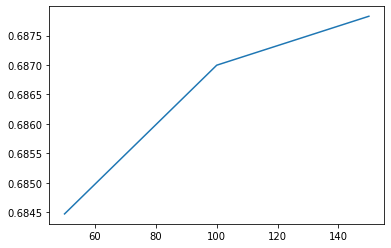

In [215]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()

### Matriz de Confusão

In [182]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_valid, preds)

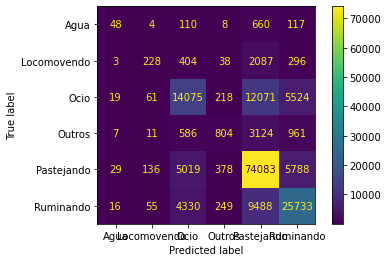

In [183]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

### Gradient Boosting

In [216]:
from xgboost import XGBClassifier

xgb_cl = XGBClassifier()
xgb_cl.fit(X_train, y_train)

/home/caio/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:35:38] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [217]:
preds_2 = xgb_cl.predict(X_valid)

accuracy_score(y_valid, preds_2)

0.6516058236592152

### Halving Grid Search CV

In [9]:
from sklearn.model_selection import HalvingGridSearchCV

param_grid = {"max_depth": [3, None],
              "min_samples_split": [5, 10]}
search = HalvingGridSearchCV(clf, param_grid, resource='n_estimators',
                              max_resources=10,
                              random_state=0).fit(X, y)
search.best_params_  
{'max_depth': None, 'min_samples_split': 10, 'n_estimators': 9}

ImportError: cannot import name 'HalvingGridSearchCV' from 'sklearn.model_selection' (/home/caio/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/__init__.py)